In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scistats
import torch
import torch.nn as nn
from GMM import gaussian_mixture_models
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import copy
import scipy.stats as scistats
%matplotlib inline

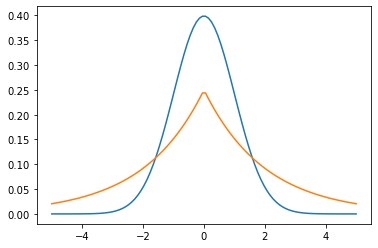

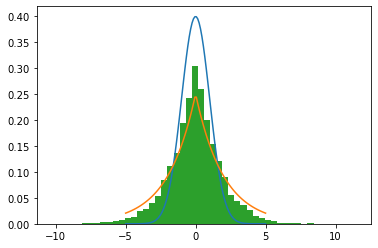

In [2]:
gauss = scistats.norm(0, 1)
laplace = scistats.laplace(0, 2)
interpolate = lambda alpha, v: (1 - alpha) * gauss.ppf(v) + (alpha) * laplace.ppf(v)
    
x_range = np.linspace(-5, 5, 100)

plt.figure()
plt.plot(x_range, gauss.pdf(x_range))
plt.plot(x_range, laplace.pdf(x_range))
plt.show()


x_new = []
alpha = 0.5

#Randomly sample
for i in range(10000):
    v = np.random.random()
    x_new.append(interpolate(alpha, v))

plt.figure()
plt.plot(x_range, gauss.pdf(x_range))
plt.plot(x_range, laplace.pdf(x_range))
plt.hist(x_new, bins = 50, density = True)
plt.show()

# Create a heteroscedastic dataset

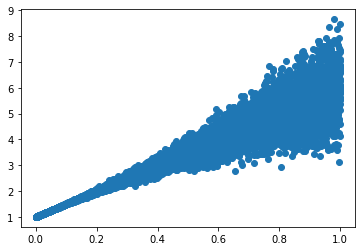

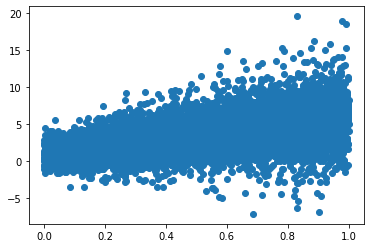

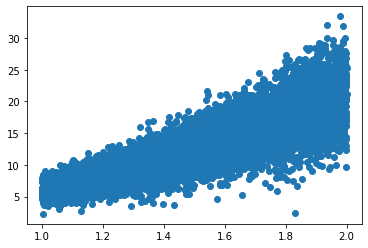

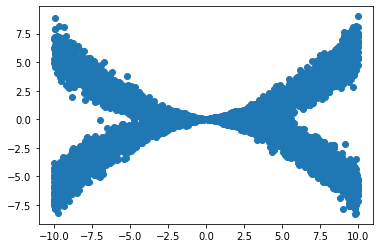

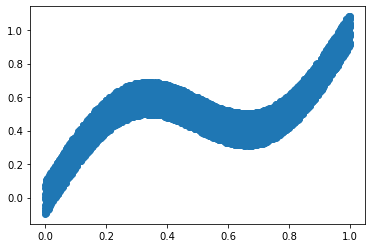

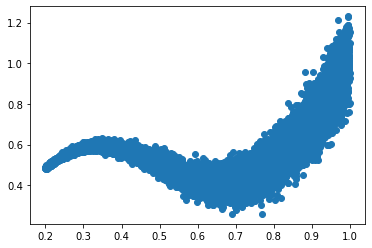

In [3]:
def linear_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n * m + c 
    noise = np.random.randn(n_samples)
    heteroscedacity = x_n**2 * noise
    
    return x_n, y_n + heteroscedacity

def linear_shift_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    gauss = scistats.norm(0, 1)
    laplace = scistats.laplace(0, 2)
    interpolate = lambda alpha, v: (1 - alpha) * gauss.ppf(v) + (alpha) * laplace.ppf(v)
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n * m + c 
    noise = np.zeros(n_samples)
    
    #Randomly sample, x acts as alpha
    for i in range(n_samples): 
        v = np.random.random() #Sample the v value
        noise[i] = interpolate(x_n[i], v)
    
    heteroscedacity = noise# * (x_n + 1)
    
    return x_n, y_n + heteroscedacity

def quadratic_sampler(n_samples, m = 5, c = 1, x_range = [1, 2]):
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n**2 * m + c 
    noise = np.random.randn(n_samples)
    heteroscedacity = x_n**2 * noise
    
    return x_n, y_n + heteroscedacity

def squared_sampler(n_samples, sigma = 0.1):
    
    binary_sampler = np.random.randint(0, 2, n_samples)

    sign = -1 * (binary_sampler == 0) + 1 * (binary_sampler == 1)

    x_n = np.random.uniform(-10, 10, n_samples)
    
    noise = np.abs(x_n) * np.random.randn(n_samples) * sigma
    y_n = sign * (x_n/4)**2 + noise
    
    return x_n, y_n

def bishop_sampler(n_samples):
    
    x_n = np.random.uniform(0, 1, n_samples)
    
    y_n = x_n + 0.3 * np.sin(2 * np.pi * x_n)
    noise = np.random.uniform(-0.1, 0.1, n_samples)
    
    return x_n, y_n + noise

def bishop_sampler_2(n_samples, sigma = 0.1):
    
    x_n = np.random.uniform(0.2, 1, n_samples)
    
    y_n = x_n + 0.3 * np.sin(2 * np.pi * x_n)
    noise = np.random.randn(n_samples) * np.abs(x_n)**2 * sigma
    
    return x_n, y_n + noise

#linear data
x, y = linear_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#linear (noise shifted) data
x, y = linear_shift_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#quadratic data
x, y = quadratic_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Squared data
x, y = squared_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Bishop data
x, y = bishop_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Bishop 2 data
x, y = bishop_sampler_2(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

# Mixture Density Network

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 23 14:22:42 2022

@author: ryanb
"""
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import copy


class mu_layer(nn.Module):
    """
    Purpose of this is to allow the user to initialise the bias of the network by adding a nn.Parameter that the user can control.
    
    This nn.Parameter module is additive to the network output.
    """
    def __init__(self, n_out_features, n_hidden, n_components, initial_params = None, bias_flag = None):
        super(mu_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")

            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            
            if self.bias_flag is None:
                self.bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_out_features)), requires_grad = False)
            
            if self.bias_flag is None:
                self.bias_flag = True
            
        self.mu_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_out_features),
                                 bias = bias_flag)
         
    def forward(self, hidden_representation):
        
        return self.mu_net(hidden_representation) + self.bias

class sigma_layer(nn.Module):
    
    def __init__(self, n_out_features, n_hidden, n_components, initial_params = None, bias_flag = None):
        super(sigma_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softplus()#lambda x: self._activation(x) + 1 + self.eps
        self.eps = 1e-8
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")
            
            #Need to adjust the bias to undo the softplus activation
            self.initial_params = np.log(np.exp(self.activation.beta * self.initial_params) - 1) / self.activation.beta
            
            #Need to adjust zero values
            #self.initial_params = initial_params * (initial_params > 0)
            
            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            
            if self.bias_flag is None:
                self.bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_out_features)), requires_grad = False)
            
            if self.bias_flag is None:
                self.bias_flag = True
            
        self.sigma_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_out_features),
                                 bias = bias_flag)
    
    def forward(self, hidden_representation):
        
        return self.activation(self.sigma_net(hidden_representation) + self.bias) + self.eps

class pi_layer(nn.Module):
    
    def __init__(self, n_out_features, n_hidden, n_components, bias_flag = False):
        super(pi_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softmax(dim = 1)
            
        self.pi_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components),
                                 bias = self.bias_flag)
        
        self.eps = 1e-8
         
    def forward(self, hidden_representation):
        
        return self.activation(self.pi_net(hidden_representation)) + self.eps #Bias does nothing, I am not sure how to initialise this well initially.
    
class feature_transform_object(object):
    
    def __init__(self, n_features, M = 1, transform_flag = False):
        """
        M = polynomial order
        """
        
        self.n_features = n_features
        self.M = M
        self.activate_transform = transform_flag
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.n_features > 1 and self.activate_transform:
            print("Feature transformer is not optimised for n_features > 1.")
            raise SystemExit
    
    def feature_transform(self, x):
        
        if self.activate_transform:
            
            x = x.detach().cpu().numpy()
            
            scale_terms = np.arange(0, self.M + 1, 1).reshape(1, -1) #M + 1 terms
            
            transform = x.reshape(-1, self.n_features)**scale_terms
            
            return torch.from_numpy(transform.astype(np.float32)).to(self.device)
        
        else:
            return x

class MixtureDensityNetwork(nn.Module):
    
    def __init__(self, n_features, n_outputs, n_components, regression_type = 'polynomial', net_dict = None, init_params = None, vectorise = True):
        """
        This implementation is for a N-dimensional Mixture density network. I emphasise here that it is N-dimensional as I 
        try to improve the code to have better initialisations and a well-trained behaviour. 
        
        regression_type = polynomial or network
        """
        super(MixtureDensityNetwork, self).__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.n_components = n_components
        self.regression_type = regression_type
        self.net_dict = net_dict
        self.init_params = init_params
        self.vectorise = vectorise
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Define the hidden network activation function
        self.activation = nn.Tanh()
        
        if self.regression_type.lower() == "polynomial":
            
            try:
                assert self.net_dict["M"] is not None
                
            except AssertionError:
                print("You have specified that the model is a {}, but M is None.".format(self.regression_type))
                print("\n", self.net_dict)
                
                raise SystemExit
            
            else:
                self.M = self.net_dict["M"]
                self.activate_transform = True
                
        elif self.regression_type.lower() == "network":
            self.M = 1
            self.activate_transform = False
            
        
        else:
            print("Unknown regression_type entered ({}).".format(self.regression_type))
            raise SystemExit
            
        #Initialise transformer
        self.transform = feature_transform_object(self.n_features, self.M, self.activate_transform)
        
        #Initialise the model
        self.initialise_model()
        
        #Initialise the optimiser
        self.initialise_optimiser()
    
    ###############################
    #MODEL INITIALISATION FUNCTIONS
    ###############################
    def initialise_model(self):
        
        if self.regression_type.lower() == "polynomial":
            
            self.hidden_net = self.transform.feature_transform
            
            self.mu_net = mu_layer(self.n_outputs, 
                                   self.M + 1,
                                   self.n_components,
                                   initial_params = None,
                                   bias_flag = False)
            
            self.sigma_net = sigma_layer(self.n_outputs, 
                                      self.M + 1,
                                      self.n_components,
                                      initial_params = None,
                                      bias_flag = False)
            
            self.pi_net = pi_layer(self.n_outputs,
                                  self.M + 1,
                                  self.n_components,
                                  bias_flag = False)
        
        else:
            
            hidden_layers = []
            
            n_layers = len(self.net_dict["ff_layers"]) -1
            
            for cnt in range(n_layers):
                
                    hidden_layers.append(nn.Linear(in_features = self.net_dict["ff_layers"][cnt], 
                                                out_features = self.net_dict["ff_layers"][cnt + 1], bias = True))
                    
                    hidden_layers.append(self.activation)
            
            self.hidden_net = nn.Sequential(*hidden_layers)
            
            #Check for initial parameters
            self.initialise_parameters()
            
            self.mu_net = mu_layer(self.n_outputs, 
                                   self.net_dict["ff_layers"][-1],
                                   self.n_components,
                                   initial_params = self.initial_params[0],
                                   bias_flag = None)
            
            self.sigma_net = sigma_layer(self.n_outputs, 
                                      self.net_dict["ff_layers"][-1],
                                      self.n_components,
                                      initial_params = self.initial_params[1],
                                      bias_flag = None)
            
            self.pi_net = pi_layer(self.n_outputs,
                                  self.net_dict["ff_layers"][-1],
                                  self.n_components,
                                  bias_flag = None)
    
    def forward(self, x):
        
        z_hidden = self.hidden_net(x)
        
        mu = self.mu_net(z_hidden)
        sigma = self.sigma_net(z_hidden)
        pi = self.pi_net(z_hidden)
        
        return mu, sigma, pi
    
    def train(self):
        
        if self.regression_type.lower() == "network":
            self.hidden_net.train()
        
        self.mu_net.train()
        self.sigma_net.train()
        self.pi_net.train()
    
    def eval(self):
        
        if self.regression_type.lower() == "network":
            self.hidden_net.eval()
        
        self.mu_net.eval()
        self.sigma_net.eval()
        self.pi_net.eval()
        
    
    def initialise_parameters(self):
        
        print("Initialisation is not yet implemented as I do not fully understand it.")
        self.initial_params = [None, None]
    
    
    ####################
    #LOSS FUNCTIONS
    ####################
    def evaluate_gauss(self, t, mu, covariance):
        
        D = t.shape[1]
        
        #Compute the precision - very simple
        precision = 1 / covariance #all diagonal terms with an isotropic Gaussian
        
        if self.vectorise:
            
            z = t - mu #t and mu are both functions of x, and hence they are both matrices
            
            first_part = 1 / ( (2 * np.pi)**(D / 2) * (torch.prod(covariance, dim = 1)**(1/2)) )
            second_part = torch.exp((-1 / 2) * torch.sum(z * z * precision, dim = 1))
            
            likelihood = first_part * second_part

        else: #Loop over the batch
            
            N = t.shape[0]
            likelihood = torch.zeros(N)
            
            for i in range(N):
                z = t[[i], :].T - mu[[i], :].T
                cov_diag = covariance[i, :]
                prec = torch.diag(1 / cov_diag)
                    
                second_part = torch.exp((-1 / 2) * torch.matmul(z.T, torch.matmul(prec, z)))
                
                first_part = 1 / ( (2 * np.pi)**(D / 2) * (torch.prod(cov_diag)**(1/2)) )
                
                likelihood[i] = first_part * second_part
        
        return likelihood
    
    def evaluate_log_gauss(self, t, mu, covariance):
        
        D = t.shape[1]
        
        first_part = -D/2 * torch.log(torch.tensor([2 * np.pi]).to(self.device)) #Constant
        
        #Compute the precision - very simple
        precision = 1 / covariance #all diagonal terms with an isotropic Gaussian
        
        if self.vectorise:
            
            z = t - mu #t and mu are both functions of x, and hence they are both matrices

            second_part = (-1 / 2) * (torch.sum(torch.log(covariance), dim = 1))
            third_part = (-1 / 2) * torch.sum(z * z * precision, dim = 1)
            
            log_likelihood = first_part + second_part + third_part

        else: #Loop over the batch
            
            N = t.shape[0]
            log_likelihood = torch.zeros(N)
            
            for i in range(N):
                z = t[[i], :].T - mu[[i], :].T
                
                cov_diag = covariance[i, :]
                prec = torch.diag(1 / cov_diag)
                
                second_part = (-1 / 2) * torch.sum(torch.log(cov_diag))
                third_part = (-1 / 2) * torch.matmul(z.T, torch.matmul(prec, z))
                
                log_likelihood[i] = first_part + second_part + third_part
        
        return log_likelihood
    
    def data_likelihood(self, t, parameter_tuple): #p(x)

        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mu, cov, mix = parameter_tuple
        
        N = t.shape[0]
        
        log_likelihoods = torch.zeros((N, self.n_components)).to(self.device)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            mix_vec = mix[:, k] #Shape is different as it comes out of a NN
            mean_mat = mu[:, start:end] #Shape is different as it comes out of a NN
            cov_mat = cov[:, start:end] #N x N matrix - sigma^2(x).I

            if N == 1:
                log_likelihoods[0, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
                
            elif N != 1 and self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
            
            if N != 1 and not self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
        
        #Apply log-sum-exp trick
        A = torch.max(log_likelihoods, dim = 1, keepdim = True)[0]
        
        log_likelihood_sum = A + torch.log(torch.sum(torch.exp(log_likelihoods - A), dim = 1, keepdim = True))
        
        p_t_G_x = torch.exp(log_likelihood_sum)
        
        return p_t_G_x, log_likelihoods, log_likelihood_sum
    
    def log_likelihood(self, t, parameter_tuple, sum_flag = False):
        
        LL = self.data_likelihood(t, parameter_tuple)[2]
        
        if sum_flag:
            return np.mean(LL)
        
        else:
            return LL
    
    def loss(self, t, parameter_tuple):
        
        NLL = -1 * self.log_likelihood(t, parameter_tuple, sum_flag = False)
        
        return torch.mean(NLL)
    
    ####################
    #OPTIMISER FUNCTIONS
    ####################
    def initialise_optimiser(self):
        
        ls = []
        
        if self.regression_type.lower() == "network":
            ls += list(self.hidden_net.parameters())
        
        ls += list(self.mu_net.parameters()) + list(self.sigma_net.parameters()) + list(self.pi_net.parameters())
        
        self.optimiser = torch.optim.AdamW(ls, lr = self.net_dict['learning_rate'])
    
    def step(self):
        self.optimiser.step()
    
    def zero_grad(self):
        self.optimiser.zero_grad()
        
    def optimise(self, t, parameter_tuple, update_flag = True):
        
        loss = self.loss(t, parameter_tuple)
        
        if update_flag:
            
            loss.backward()
            self.step()
            self.zero_grad()
        
        return loss.detach().cpu().numpy()
    
    ####################
    #TRAINING FUNCTIONS
    ####################
    def fit(self, training_iterator, validation_iterator, epochs, vis_range = [0.1, 2]):
        
        #Save the training stuff
        self.train_iterator = training_iterator#iter(training_iterator)
        self.valid_iterator = validation_iterator#iter(validation_iterator)
        self.epochs = epochs
        
        #Train the model
        self.train_model(vis_range)
    
    def train_model(self, vis_range, visualise_training = False):
        
        cost_train_list = []
        cost_valid_list = []
        min_loss = np.inf
        pbar = tqdm(total = self.epochs, desc = "Cost at epoch {}: {}".format(0, np.inf))
        self.to(self.device)
        
        self.current_epoch_no = 0
        
        for i in range(self.epochs):
            
            cost_train = 0
            cnt_train = 0
            self.train()
            
            for data in self.train_iterator:
                if isinstance(data, list):#tuple): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    T = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    T = None
                    
                parameter_tuple = self.forward(Xdata)

                cost_train += self.optimise(T, parameter_tuple, update_flag = True)

                cnt_train += 1
            
            #Save data
            cost_train_list.append([cost_train / cnt_train])
            
            
            #Validation
            cost_valid = 0
            cnt_valid = 0
            self.eval()
            
            for data in self.valid_iterator:
                if isinstance(data, list):#tuple): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    T = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    T = None
                    
                parameter_tuple = self.forward(Xdata)

                cost_valid += self.optimise(T, parameter_tuple, update_flag = False)

                cnt_valid += 1
            
            #Save data
            cost_valid_list.append([cost_valid / cnt_valid])
            
            #Store optimal
            if cost_train_list[-1][0] < min_loss:
                min_loss = cost_train_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = copy.deepcopy(self.state_dict()) #Save the optimal state dict
                self.index_min_valid = i
            
            #Update pbar
            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1][0], cost_valid_list[-1][0]))
            pbar.update(1)
            
            #Visualise
            
            if i % 50 == 0 and self.n_features == 1 and self.n_outputs == 1 and visualise_training:
                x_range = np.linspace(vis_range[0], vis_range[1], 1000)
                X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(self.device)

                with torch.no_grad():
                    mu, sigma, pi = self.forward(X)
                    mean = self.mean(X).detach().cpu().numpy()
                    mode = self.mode(X).detach().cpu().numpy()
                    variance = self.variance(X).detach().cpu().numpy()

                    mu = mu.cpu().numpy()
                    sigma = sigma.cpu().numpy()
                    pi = pi.cpu().numpy()
                    mean = mean[:, 0]
                    variance = variance[:, 0]

                    fig, ax = plt.subplots(1, self.n_components, figsize = (14, 6))
                    
                    try:
                        ax = ax.flatten()
                        
                    except:
                        ax = [ax]

                    for i in range(mu.shape[1]):
                        ax[i].plot(x_range, mu[:, i], "k--", label  = "component {}".format(i + 1))
                        ax[i].fill_between(x_range, mu[:, i] - 3 * np.sqrt(sigma[:, i]) , mu[:, i] + 3 * np.sqrt(sigma[:, i]), alpha = 0.5)

                    for axs in ax:
                        axs.grid()
                        axs.legend()
                        axs.set_xlabel(r"$\omega$")

                    fig.tight_layout()
                    plt.show()

                    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
                    ax = ax.flatten()

                    for i in range(self.n_components):
                        ax[0].plot(x_range, pi[:, i], label  = r"$\pi_{}(x)$".format("{" + str(i + 1) + "}"))

                    ax[1].plot(x_range, mean, "k--", label  = "conditional average")
                    ax[1].plot(x_range, mode, "r-.", label  = "approximate conditional mode")
                    ax[1].fill_between(x_range, mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), color = "b", alpha = 0.5, label = "variance")

                    for axs in ax:
                        axs.grid()
                        axs.legend()
                        axs.set_xlabel(r"$\omega$")

                    fig.tight_layout()
                    plt.show()
        
        pbar.close()
    
        #Finish training
        self.min_loss = min_loss
        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list
        self.eval()
    
    def plotter(self):
        v1 = np.array(self.train_cost)
        v2 = np.array(self.valid_cost)
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
        
        ax.set_title("Training curves")
        ax.plot(v1[:, 0], label = "Training loss")
        ax.plot(v2[:, 0], label = "Validation loss")
        #ax.scatter([self.index_min_valid] * v1.shape[1], v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax.legend()

        ax.grid()
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost")
            
        fig.tight_layout()
        #plt.savefig("./tmp/oc_nn_losses.png")
        #plt.savefig("./tmp/oc_nn_losses.pdf")
        plt.show()
    
    def sample(self, n_samples):
        
        pass
    
    def score_samples(self, t, x):
        
        parameter_tuple = self.forward(x)
        
        return self.log_likelihood(t, parameter_tuple)
    
    def mean(self, x):
        
        mean_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            mean_tensor += mu[:, start:end] * pi[:, [k]]
        
        return mean_tensor
    
    def mode(self, x):
        
        mode_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        max_pi = torch.max(pi, dim = 1)[1]
        max_pi = max_pi.detach().cpu().numpy()
        
        start = max_pi * self.n_outputs
        end = (max_pi + 1) * self.n_outputs
        
        for i in range(x.size(0)):
            start = max_pi[i] * self.n_outputs
            end = (max_pi[i] + 1) * self.n_outputs
            
            mode_tensor[i, :] = mu[i, start:end]
        
        return mode_tensor
    
    def variance(self, x):
        
        variance_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        mean = self.mean(x)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            variance_tensor += pi[:, [k]] * (sigma[:, start:end] + torch.sum((mu[:, start:end] - mean)**2, dim = 1, keepdim = True))
            
        return variance_tensor
    
    def transform_data(self, t, x):
        
        mean = self.mean(x)
        variance = self.variance(x)
        
        nll = -1 * self.score_samples(t, x)
        
        x_transform = (t - mean) / torch.sqrt(variance)
        
        return x_transform.cpu().numpy(), nll.cpu().numpy()


# Testing the model

n_features = 1
n_components = 2
n_outputs = 1
net_dict = {"ff_layers":[n_features, 10, 10, n_outputs],
            "M":4,
            "learning_rate":1e-4}

test_model = MixtureDensityNetwork(n_features,
                                   n_outputs,
                                   n_components, 
                                   "polynomial", 
                                   net_dict, 
                                   init_params = "k-means", 
                                   verbose = True,
                                   vectorise = True)

with torch.no_grad():
    x = torch.from_numpy(np.array([[1, 2, 3, 4, 5, 6, 7]]).astype(np.float32).T) * 0.1

    #Test the feature transformer
    print(x)
    #print(test_model.transform.feature_transform(x))

    #Visualise the model
    print(test_model)

    test_mu, test_sigma, test_pi = test_model(x)
    
    print("Test mu:\n{}\n\n".format(test_mu))
    print("Test sigma:\n{}\n\n".format(test_sigma))
    print("Test pi:\n{}\n\n".format(test_pi))
    

    #Test the likelihood and log-likelihood on a 1D problem:
    
    for k in range(test_model.n_components):
        start = k * n_outputs
        end = (k + 1) * n_outputs

        print("\n\nK = {}".format(k))
        print(start, end)

        mu_k = test_mu[:, start:end]
        sigma_k = test_sigma[:, start:end]
        pi_k = test_pi[:, start:end]
        
        print("mu_k:\n{}\n\n".format(mu_k))
        print("sigma_k:\n{}\n\n".format(sigma_k))
        print("pi_k:\n{}\n\n".format(pi_k))

        print(mu_k.size(), sigma_k.size(), pi_k.size())

        gauss = test_model.evaluate_gauss(x, mu_k, sigma_k)
        log_gauss = test_model.evaluate_log_gauss(x, mu_k, sigma_k)
        error = log_gauss - torch.log(gauss)
        print("Gauss likelihood: {}".format(gauss))
        print("Gauss log-likelihood: {}".format(log_gauss))
        print("Error: {}".format(error))
    
    l_f, log_likelihoods, log_likelihood_f = test_model.data_likelihood(x, (test_mu, test_sigma, test_pi))
    
    print(l_f, "\n\n", log_likelihoods, "\n\n", log_likelihood_f, "\n\n")
    
    #Check that log-sum-exp is working as expected:
    print(torch.log(torch.sum(torch.exp(log_likelihoods), dim = 1)), "\n\n")

# Develop training and validation iterators

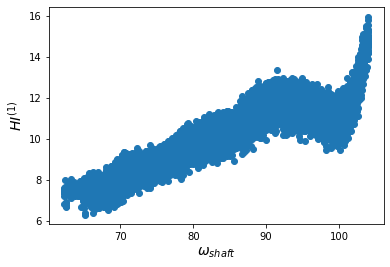

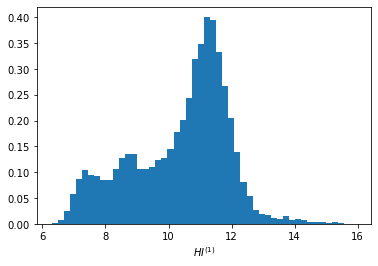

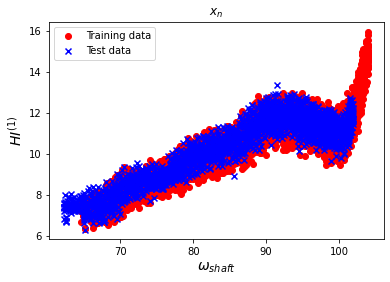

In [10]:
%matplotlib inline
#Datasets
#omega_n, HI_n = linear_sampler(10000)
#omega_n, HI_n = linear_shift_sampler(10000)
#omega_n, HI_n = quadratic_sampler(10000, x_range= [0.1, 2])
#HI_n, omega_n  = bishop_sampler(10000)#omega_n, HI_n  = bishop_sampler(10000)#
#omega_n, HI_n = bishop_sampler_2(10000)
#omega_n, HI_n = squared_sampler(10000, sigma = 0.1)

omega_all = np.load("omega_mat.npy") * 2 * np.pi
HI_all = np.load("LHI_mat.npy")

omega_n = omega_all[:25, :].reshape(-1)
HI_n = HI_all[:25, :].reshape(-1)

#print(omega_n.shape)


plt.figure()#plt.title(r"$y(x) = 5x + (x^2 \times \epsilon)$")
#plt.title(r"$x_n$")
plt.scatter(omega_n, HI_n) 
plt.xlabel(r"$\omega_{shaft}$", fontsize = 14)
plt.ylabel(r"$HI^{(1)}$", fontsize = 14)
plt.show()

plt.figure()
plt.hist(HI_n, bins = 50, density = True)
plt.xlabel(r"$HI^{(1)}$")
plt.show()

split_frac = 0.8
split_index = int(len(HI_n) * split_frac)

Xtrain, Xtest = omega_n[:split_index], omega_n[split_index:]
Ytrain, Ytest = HI_n[:split_index], HI_n[split_index:]

plt.title(r"$x_n$")
plt.scatter(Xtrain, Ytrain, color = "r", label = "Training data")
plt.scatter(Xtest, Ytest, color = "b", marker = "x", label = "Test data")
plt.xlabel(r"$\omega_{shaft}$", fontsize = 14)
plt.ylabel(r"$HI^{(1)}$", fontsize = 14)
plt.legend()
plt.show()

train_dataset = TensorDataset(torch.from_numpy(Xtrain.astype(np.float32).reshape(-1, 1)), 
                              torch.from_numpy(Ytrain.astype(np.float32).reshape(-1, 1)))

test_dataset = TensorDataset(torch.from_numpy(Xtest.astype(np.float32).reshape(-1, 1)), 
                             torch.from_numpy(Ytest.astype(np.float32).reshape(-1, 1)))

train_dataloader = DataLoader(train_dataset, 
                              batch_size=512, 
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=512, 
                             shuffle=False)

# Initialise the model

In [23]:
n_features = 1
n_components = 1
n_outputs = 1

net_dict = {"ff_layers":[n_features, 25, 25, 25],
            "M":5,
            "learning_rate":5e-3}

model = MixtureDensityNetwork(n_features,
                               n_outputs,
                               n_components, 
                               "network", 
                               net_dict, 
                               init_params = "k-means", 
                               vectorise = True)

Initialisation is not yet implemented as I do not fully understand it.


# Train the model

MixtureDensityNetwork(
  (activation): Tanh()
  (hidden_net): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
  )
  (mu_net): mu_layer(
    (mu_net): Linear(in_features=25, out_features=1, bias=False)
  )
  (sigma_net): sigma_layer(
    (activation): Softplus(beta=1, threshold=20)
    (sigma_net): Linear(in_features=25, out_features=1, bias=False)
  )
  (pi_net): pi_layer(
    (activation): Softmax(dim=1)
    (pi_net): Linear(in_features=25, out_features=1, bias=False)
  )
)



Cost at epoch 0: inf:   0%|                                                                    | 0/500 [00:00<?, ?it/s]
train cost: 30.646850334970576, valid cost: 11.85201816558838:   0%|                           | 0/500 [00:00<?, ?it/s]
train cost: 30.646850334970576, valid cost: 11.85201816558838:   0%|                   | 1/500 [00:00<03:13,  2.57it/s]
train cost: 8.70092023046393, valid cost: 6.197051239013672:   0%|                     | 1/500 [00:00<03:13,  2.57it/s]
train cost: 8.70092023046393, valid cost: 6.197051239013672:   0%|                     | 2/500 [00:00<03:47,  2.19it/s]
train cost: 5.133589945341411, valid cost: 4.127756786346436:   0%|                    | 2/500 [00:01<03:47,  2.19it/s]
train cost: 5.133589945341411, valid cost: 4.127756786346436:   1%|                    | 3/500 [00:01<03:35,  2.30it/s]
train cost: 3.641903337679411, valid cost: 3.135097551345825:   1%|                    | 3/500 [00:01<03:35,  2.30it/s]
train cost: 3.641903337679411, valid co

train cost: 1.888994812965393, valid cost: 1.8831864833831786:   7%|█▏                | 33/500 [00:13<02:51,  2.73it/s]
train cost: 1.8838649737207513, valid cost: 1.8782512187957763:   7%|█                | 33/500 [00:13<02:51,  2.73it/s]
train cost: 1.8838649737207513, valid cost: 1.8782512187957763:   7%|█▏               | 34/500 [00:13<02:51,  2.72it/s]
train cost: 1.879230116543017, valid cost: 1.8738335609436034:   7%|█▏                | 34/500 [00:13<02:51,  2.72it/s]
train cost: 1.879230116543017, valid cost: 1.8738335609436034:   7%|█▎                | 35/500 [00:13<02:50,  2.73it/s]
train cost: 1.8750411083823757, valid cost: 1.8697338819503784:   7%|█▏               | 35/500 [00:14<02:50,  2.73it/s]
train cost: 1.8750411083823757, valid cost: 1.8697338819503784:   7%|█▏               | 36/500 [00:14<02:49,  2.74it/s]
train cost: 1.871399578295256, valid cost: 1.8663001775741577:   7%|█▎                | 36/500 [00:14<02:49,  2.74it/s]
train cost: 1.871399578295256, valid cos

train cost: 1.8585256338119507, valid cost: 1.8545300960540771:  13%|██▏              | 66/500 [00:23<02:12,  3.28it/s]
train cost: 1.8589731078398855, valid cost: 1.8541273593902587:  13%|██▏              | 66/500 [00:23<02:12,  3.28it/s]
train cost: 1.8589731078398855, valid cost: 1.8541273593902587:  13%|██▎              | 67/500 [00:23<02:14,  3.22it/s]
train cost: 1.8586419507076866, valid cost: 1.8548962593078613:  13%|██▎              | 67/500 [00:23<02:14,  3.22it/s]
train cost: 1.8586419507076866, valid cost: 1.8548962593078613:  14%|██▎              | 68/500 [00:23<02:15,  3.19it/s]
train cost: 1.8584057469117015, valid cost: 1.8540736436843872:  14%|██▎              | 68/500 [00:23<02:15,  3.19it/s]
train cost: 1.8584057469117015, valid cost: 1.8540736436843872:  14%|██▎              | 69/500 [00:23<02:18,  3.12it/s]
train cost: 1.8586184853001644, valid cost: 1.8544132709503174:  14%|██▎              | 69/500 [00:24<02:18,  3.12it/s]
train cost: 1.8586184853001644, valid co

train cost: 1.846051065545333, valid cost: 1.827516460418701:  20%|███▊               | 99/500 [00:31<01:32,  4.35it/s]
train cost: 1.809411695128993, valid cost: 1.7486230850219726:  20%|███▌              | 99/500 [00:32<01:32,  4.35it/s]
train cost: 1.809411695128993, valid cost: 1.7486230850219726:  20%|███▍             | 100/500 [00:32<01:30,  4.40it/s]
train cost: 1.630954014627557, valid cost: 1.5994126319885253:  20%|███▍             | 100/500 [00:32<01:30,  4.40it/s]
train cost: 1.630954014627557, valid cost: 1.5994126319885253:  20%|███▍             | 101/500 [00:32<01:34,  4.20it/s]
train cost: 1.4295770494561446, valid cost: 1.2369275331497191:  20%|███▏            | 101/500 [00:32<01:34,  4.20it/s]
train cost: 1.4295770494561446, valid cost: 1.2369275331497191:  20%|███▎            | 102/500 [00:32<01:32,  4.32it/s]
train cost: 1.1858779756646407, valid cost: 0.9954076409339905:  20%|███▎            | 102/500 [00:32<01:32,  4.32it/s]
train cost: 1.1858779756646407, valid co

train cost: 0.9127322529491625, valid cost: 0.8183851599693298:  26%|████▏           | 132/500 [00:40<01:40,  3.65it/s]
train cost: 0.9203122760120191, valid cost: 0.8312767744064331:  26%|████▏           | 132/500 [00:40<01:40,  3.65it/s]
train cost: 0.9203122760120191, valid cost: 0.8312767744064331:  27%|████▎           | 133/500 [00:40<01:34,  3.90it/s]
train cost: 0.9331235289573669, valid cost: 0.8314258694648743:  27%|████▎           | 133/500 [00:41<01:34,  3.90it/s]
train cost: 0.9331235289573669, valid cost: 0.8314258694648743:  27%|████▎           | 134/500 [00:41<01:41,  3.61it/s]
train cost: 0.9148914782624495, valid cost: 0.8096750736236572:  27%|████▎           | 134/500 [00:41<01:41,  3.61it/s]
train cost: 0.9148914782624495, valid cost: 0.8096750736236572:  27%|████▎           | 135/500 [00:41<01:38,  3.71it/s]
train cost: 0.9408173749321386, valid cost: 0.821272325515747:  27%|████▌            | 135/500 [00:41<01:38,  3.71it/s]
train cost: 0.9408173749321386, valid co

train cost: 0.927437823069723, valid cost: 0.9253252148628235:  33%|█████▌           | 165/500 [00:50<01:47,  3.13it/s]
train cost: 0.9334352173303303, valid cost: 0.8027044534683228:  33%|█████▎          | 165/500 [00:50<01:47,  3.13it/s]
train cost: 0.9334352173303303, valid cost: 0.8027044534683228:  33%|█████▎          | 166/500 [00:50<01:44,  3.19it/s]
train cost: 0.9020546329648871, valid cost: 0.8719359755516052:  33%|█████▎          | 166/500 [00:50<01:44,  3.19it/s]
train cost: 0.9020546329648871, valid cost: 0.8719359755516052:  33%|█████▎          | 167/500 [00:50<01:46,  3.11it/s]
train cost: 0.9056323829450106, valid cost: 0.8302351951599121:  33%|█████▎          | 167/500 [00:51<01:46,  3.11it/s]
train cost: 0.9056323829450106, valid cost: 0.8302351951599121:  34%|█████▍          | 168/500 [00:51<01:40,  3.29it/s]
train cost: 0.9050707095547726, valid cost: 0.8235046863555908:  34%|█████▍          | 168/500 [00:51<01:40,  3.29it/s]
train cost: 0.9050707095547726, valid co

train cost: 0.8775964191085414, valid cost: 0.9409901738166809:  40%|██████▎         | 198/500 [01:01<01:55,  2.62it/s]
train cost: 0.8916732543393185, valid cost: 0.8069766283035278:  40%|██████▎         | 198/500 [01:02<01:55,  2.62it/s]
train cost: 0.8916732543393185, valid cost: 0.8069766283035278:  40%|██████▎         | 199/500 [01:02<01:48,  2.77it/s]
train cost: 0.9053063549493489, valid cost: 0.778788423538208:  40%|██████▊          | 199/500 [01:02<01:48,  2.77it/s]
train cost: 0.9053063549493489, valid cost: 0.778788423538208:  40%|██████▊          | 200/500 [01:02<01:46,  2.80it/s]
train cost: 0.8805834431397287, valid cost: 0.793129050731659:  40%|██████▊          | 200/500 [01:02<01:46,  2.80it/s]
train cost: 0.8805834431397287, valid cost: 0.793129050731659:  40%|██████▊          | 201/500 [01:02<01:49,  2.73it/s]
train cost: 0.8697067969723752, valid cost: 0.7956104874610901:  40%|██████▍         | 201/500 [01:03<01:49,  2.73it/s]
train cost: 0.8697067969723752, valid co

train cost: 0.8196232475732502, valid cost: 0.7737761974334717:  46%|███████▍        | 231/500 [01:12<01:31,  2.95it/s]
train cost: 0.8290712519695884, valid cost: 0.9100777864456177:  46%|███████▍        | 231/500 [01:13<01:31,  2.95it/s]
train cost: 0.8290712519695884, valid cost: 0.9100777864456177:  46%|███████▍        | 232/500 [01:13<01:28,  3.03it/s]
train cost: 0.8369562155322025, valid cost: 0.7572664499282837:  46%|███████▍        | 232/500 [01:13<01:28,  3.03it/s]
train cost: 0.8369562155322025, valid cost: 0.7572664499282837:  47%|███████▍        | 233/500 [01:13<01:22,  3.22it/s]
train cost: 0.827638704525797, valid cost: 0.777451503276825:  47%|████████▍         | 233/500 [01:13<01:22,  3.22it/s]
train cost: 0.827638704525797, valid cost: 0.777451503276825:  47%|████████▍         | 234/500 [01:13<01:23,  3.18it/s]
train cost: 0.8273986797583731, valid cost: 0.7926491975784302:  47%|███████▍        | 234/500 [01:14<01:23,  3.18it/s]
train cost: 0.8273986797583731, valid co

train cost: 0.7396307117060611, valid cost: 0.7495033502578735:  53%|████████▍       | 264/500 [01:23<01:15,  3.11it/s]
train cost: 0.7221609322648299, valid cost: 0.73655264377594:  53%|█████████▌        | 264/500 [01:23<01:15,  3.11it/s]
train cost: 0.7221609322648299, valid cost: 0.73655264377594:  53%|█████████▌        | 265/500 [01:23<01:15,  3.10it/s]
train cost: 0.7954782247543335, valid cost: 0.7668790459632874:  53%|████████▍       | 265/500 [01:23<01:15,  3.10it/s]
train cost: 0.7954782247543335, valid cost: 0.7668790459632874:  53%|████████▌       | 266/500 [01:23<01:12,  3.21it/s]
train cost: 0.7411482490991291, valid cost: 0.7820652842521667:  53%|████████▌       | 266/500 [01:24<01:12,  3.21it/s]
train cost: 0.7411482490991291, valid cost: 0.7820652842521667:  53%|████████▌       | 267/500 [01:24<01:13,  3.18it/s]
train cost: 0.7191838277013678, valid cost: 0.695080304145813:  53%|█████████        | 267/500 [01:24<01:13,  3.18it/s]
train cost: 0.7191838277013678, valid co

train cost: 0.7235695719718933, valid cost: 0.7021492004394532:  59%|█████████▌      | 297/500 [01:32<00:56,  3.60it/s]
train cost: 0.6979792180814242, valid cost: 0.7585106015205383:  59%|█████████▌      | 297/500 [01:33<00:56,  3.60it/s]
train cost: 0.6979792180814242, valid cost: 0.7585106015205383:  60%|█████████▌      | 298/500 [01:33<00:56,  3.55it/s]
train cost: 0.6900364254650316, valid cost: 0.7695024132728576:  60%|█████████▌      | 298/500 [01:33<00:56,  3.55it/s]
train cost: 0.6900364254650316, valid cost: 0.7695024132728576:  60%|█████████▌      | 299/500 [01:33<00:56,  3.53it/s]
train cost: 0.6867738021047491, valid cost: 0.7239027976989746:  60%|█████████▌      | 299/500 [01:33<00:56,  3.53it/s]
train cost: 0.6867738021047491, valid cost: 0.7239027976989746:  60%|█████████▌      | 300/500 [01:33<00:55,  3.58it/s]
train cost: 0.7039396794218766, valid cost: 0.7058134317398072:  60%|█████████▌      | 300/500 [01:33<00:55,  3.58it/s]
train cost: 0.7039396794218766, valid co

train cost: 0.7086206047158492, valid cost: 0.7648044109344483:  66%|██████████▌     | 330/500 [01:41<00:44,  3.81it/s]
train cost: 0.6834058008695904, valid cost: 0.7073932647705078:  66%|██████████▌     | 330/500 [01:41<00:44,  3.81it/s]
train cost: 0.6834058008695904, valid cost: 0.7073932647705078:  66%|██████████▌     | 331/500 [01:41<00:44,  3.77it/s]
train cost: 0.7822374230936954, valid cost: 0.7541389465332031:  66%|██████████▌     | 331/500 [01:41<00:44,  3.77it/s]
train cost: 0.7822374230936954, valid cost: 0.7541389465332031:  66%|██████████▌     | 332/500 [01:41<00:46,  3.59it/s]
train cost: 0.7183289308297006, valid cost: 0.7340429425239563:  66%|██████████▌     | 332/500 [01:42<00:46,  3.59it/s]
train cost: 0.7183289308297006, valid cost: 0.7340429425239563:  67%|██████████▋     | 333/500 [01:42<00:43,  3.80it/s]
train cost: 0.6781975344607705, valid cost: 0.7315428256988525:  67%|██████████▋     | 333/500 [01:42<00:43,  3.80it/s]
train cost: 0.6781975344607705, valid co

train cost: 0.6983963502080817, valid cost: 0.7138024806976319:  73%|███████████▌    | 363/500 [01:49<00:32,  4.24it/s]
train cost: 0.7028632352226659, valid cost: 0.7098011136054992:  73%|███████████▌    | 363/500 [01:49<00:32,  4.24it/s]
train cost: 0.7028632352226659, valid cost: 0.7098011136054992:  73%|███████████▋    | 364/500 [01:49<00:32,  4.17it/s]
train cost: 0.6926765849715785, valid cost: 0.8505085825920105:  73%|███████████▋    | 364/500 [01:50<00:32,  4.17it/s]
train cost: 0.6926765849715785, valid cost: 0.8505085825920105:  73%|███████████▋    | 365/500 [01:50<00:35,  3.83it/s]
train cost: 0.6949296436811748, valid cost: 0.7592524528503418:  73%|███████████▋    | 365/500 [01:50<00:35,  3.83it/s]
train cost: 0.6949296436811748, valid cost: 0.7592524528503418:  73%|███████████▋    | 366/500 [01:50<00:34,  3.91it/s]
train cost: 0.7354252652118081, valid cost: 0.737529742717743:  73%|████████████▍    | 366/500 [01:50<00:34,  3.91it/s]
train cost: 0.7354252652118081, valid co

train cost: 0.6706811252393221, valid cost: 0.8874072670936585:  79%|████████████▋   | 396/500 [01:57<00:26,  3.97it/s]
train cost: 0.7067223473599082, valid cost: 0.7417020916938781:  79%|████████████▋   | 396/500 [01:57<00:26,  3.97it/s]
train cost: 0.7067223473599082, valid cost: 0.7417020916938781:  79%|████████████▋   | 397/500 [01:57<00:26,  3.93it/s]
train cost: 0.7189155377839741, valid cost: 0.6905758023262024:  79%|████████████▋   | 397/500 [01:58<00:26,  3.93it/s]
train cost: 0.7189155377839741, valid cost: 0.6905758023262024:  80%|████████████▋   | 398/500 [01:58<00:25,  3.93it/s]
train cost: 0.7259713881894162, valid cost: 0.7396982669830322:  80%|████████████▋   | 398/500 [01:58<00:25,  3.93it/s]
train cost: 0.7259713881894162, valid cost: 0.7396982669830322:  80%|████████████▊   | 399/500 [01:58<00:25,  3.98it/s]
train cost: 0.677067966837632, valid cost: 0.8180639266967773:  80%|█████████████▌   | 399/500 [01:58<00:25,  3.98it/s]
train cost: 0.677067966837632, valid cos

train cost: 0.6719312416879755, valid cost: 0.6995980501174927:  86%|█████████████▋  | 429/500 [02:06<00:18,  3.86it/s]
train cost: 0.6786277858834517, valid cost: 0.7864224672317505:  86%|█████████████▋  | 429/500 [02:06<00:18,  3.86it/s]
train cost: 0.6786277858834517, valid cost: 0.7864224672317505:  86%|█████████████▊  | 430/500 [02:06<00:17,  3.94it/s]
train cost: 0.6592893318126076, valid cost: 0.8212746620178223:  86%|█████████████▊  | 430/500 [02:06<00:17,  3.94it/s]
train cost: 0.6592893318126076, valid cost: 0.8212746620178223:  86%|█████████████▊  | 431/500 [02:06<00:17,  4.02it/s]
train cost: 0.7006648339723286, valid cost: 0.7087616205215455:  86%|█████████████▊  | 431/500 [02:06<00:17,  4.02it/s]
train cost: 0.7006648339723286, valid cost: 0.7087616205215455:  86%|█████████████▊  | 432/500 [02:06<00:16,  4.10it/s]
train cost: 0.7021970937126562, valid cost: 0.7001974821090698:  86%|█████████████▊  | 432/500 [02:07<00:16,  4.10it/s]
train cost: 0.7021970937126562, valid co

train cost: 0.718811317494041, valid cost: 0.7685402512550354:  92%|███████████████▋ | 462/500 [02:14<00:09,  4.19it/s]
train cost: 0.6864248702400609, valid cost: 0.7262016177177429:  92%|██████████████▊ | 462/500 [02:14<00:09,  4.19it/s]
train cost: 0.6864248702400609, valid cost: 0.7262016177177429:  93%|██████████████▊ | 463/500 [02:14<00:08,  4.17it/s]
train cost: 0.6618697392313104, valid cost: 0.7163394093513489:  93%|██████████████▊ | 463/500 [02:14<00:08,  4.17it/s]
train cost: 0.6618697392313104, valid cost: 0.7163394093513489:  93%|██████████████▊ | 464/500 [02:14<00:08,  4.13it/s]
train cost: 0.6670045193872953, valid cost: 0.8031725764274598:  93%|██████████████▊ | 464/500 [02:14<00:08,  4.13it/s]
train cost: 0.6670045193872953, valid cost: 0.8031725764274598:  93%|██████████████▉ | 465/500 [02:14<00:08,  4.07it/s]
train cost: 0.665048128680179, valid cost: 0.7289542198181153:  93%|███████████████▊ | 465/500 [02:15<00:08,  4.07it/s]
train cost: 0.665048128680179, valid cos

train cost: 0.7415501036142048, valid cost: 0.9164739966392517:  99%|███████████████▊| 495/500 [02:22<00:01,  3.38it/s]
train cost: 0.7738811405081498, valid cost: 0.790686821937561:  99%|████████████████▊| 495/500 [02:22<00:01,  3.38it/s]
train cost: 0.7738811405081498, valid cost: 0.790686821937561:  99%|████████████████▊| 496/500 [02:22<00:01,  3.53it/s]
train cost: 0.713304412992377, valid cost: 0.8793620467185974:  99%|████████████████▊| 496/500 [02:23<00:01,  3.53it/s]
train cost: 0.713304412992377, valid cost: 0.8793620467185974:  99%|████████████████▉| 497/500 [02:23<00:00,  3.63it/s]
train cost: 0.7113844187636125, valid cost: 0.7684720993041992:  99%|███████████████▉| 497/500 [02:23<00:00,  3.63it/s]
train cost: 0.7113844187636125, valid cost: 0.7684720993041992: 100%|███████████████▉| 498/500 [02:23<00:00,  3.78it/s]
train cost: 0.7006967601023222, valid cost: 0.8237805604934693: 100%|███████████████▉| 498/500 [02:23<00:00,  3.78it/s]
train cost: 0.7006967601023222, valid co

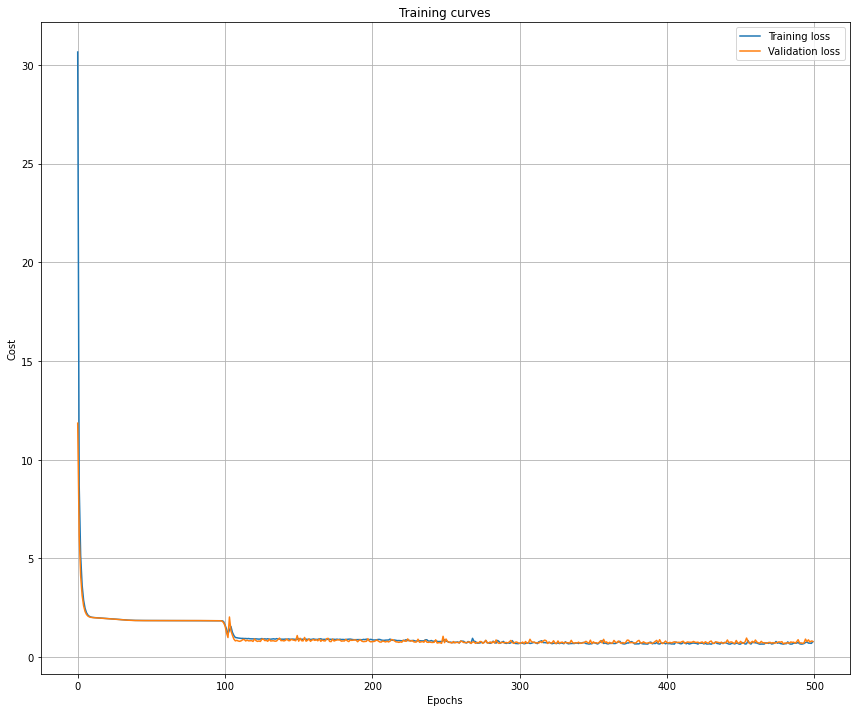

<All keys matched successfully>

In [24]:
print(model)

model.fit(train_dataloader, test_dataloader, 500, vis_range=[np.min(omega_n), np.max(omega_n)])
model.plotter()

model.load_state_dict(model.optimal_state_dict)

# Test the model

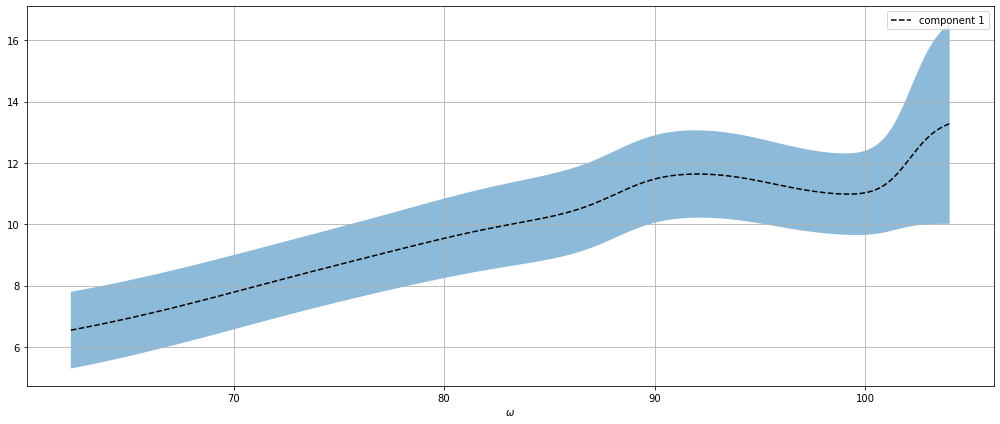

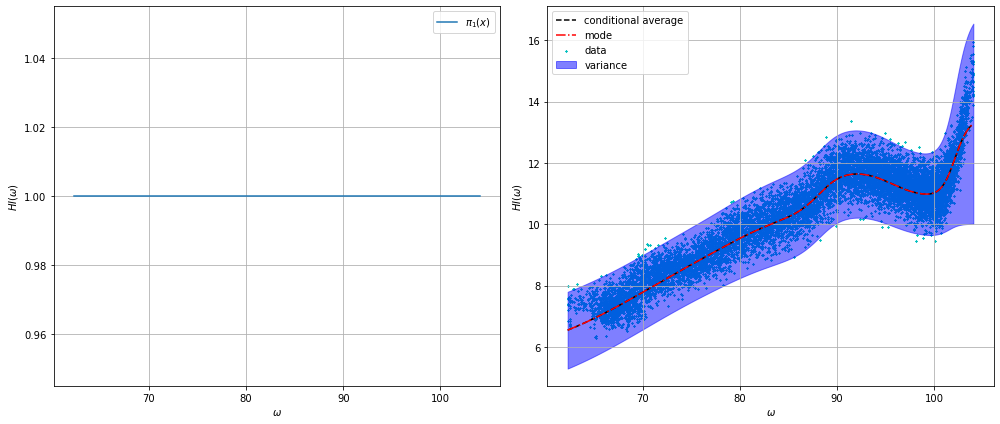

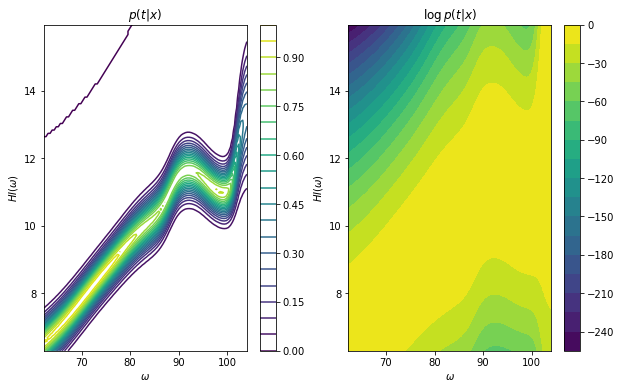

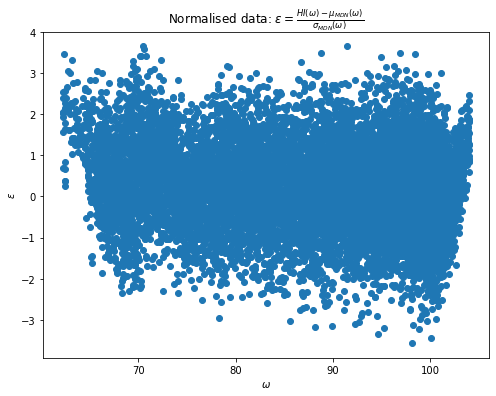

torch.Size([291600, 1]) torch.Size([291600, 1])


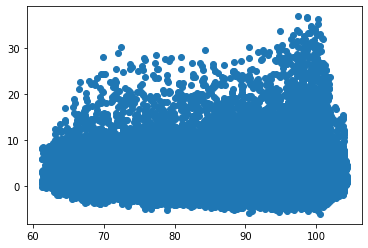

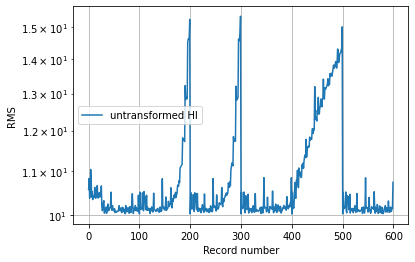

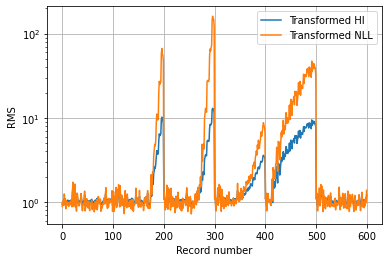

In [26]:
x_range = np.linspace(np.min(omega_n), np.max(omega_n), 1000)
X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(model.device)

with torch.no_grad():
    mu, sigma, pi = model(X)
    
    mean = model.mean(X).detach().cpu().numpy()
    mode = model.mode(X).detach().cpu().numpy()
    variance = model.variance(X).detach().cpu().numpy()
    
    mu = mu.cpu().numpy()
    sigma = sigma.cpu().numpy()
    pi = pi.cpu().numpy()
    mean = mean[:, 0]
    variance = variance[:, 0]
    
    fig, ax = plt.subplots(1, n_components, figsize = (14, 6))
    
    try:
        ax = ax.flatten()
        
    except:
        ax = [ax]
    
    for i in range(mu.shape[1]):
        ax[i].plot(x_range, mu[:, i], "k--", label  = "component {}".format(i + 1))
        ax[i].fill_between(x_range, mu[:, i] - 3 * np.sqrt(sigma[:, i]) , mu[:, i] + 3 * np.sqrt(sigma[:, i]), alpha = 0.5)
    
    for axs in ax:
        axs.grid()
        axs.legend()
        axs.set_xlabel(r"$\omega$")
        
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
    ax = ax.flatten()
    
    for i in range(n_components):
        ax[0].plot(x_range, pi[:, i], label  = r"$\pi_{}(x)$".format("{" + str(i + 1) + "}"))
    
    ax[1].plot(x_range, mean, "k--", label  = "conditional average")
    ax[1].plot(x_range, mode, "r-.", label  = "mode")
    ax[1].scatter(omega_n, HI_n, marker = "x", s = 2, c = "c", label = "data") 
    ax[1].fill_between(x_range, mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), color = "b", alpha = 0.5, label = "variance")
    
    for axs in ax:
        axs.grid()
        axs.legend()
        axs.set_xlabel(r"$\omega$")
        axs.set_ylabel(r"$HI(\omega)$")
        
    fig.tight_layout()
    plt.show()
    
    N = 100
    x_range, t_range = np.meshgrid(np.linspace(np.min(omega_n), np.max(omega_n), N), 
                                   np.linspace(np.min(HI_n), np.max(HI_n), N))
    
    X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(model.device)
    T = torch.from_numpy(t_range.astype(np.float32).reshape(-1, 1)).to(model.device)
    
    parameter_tuple = model(X)
    p_t_G_x, _, log_p_t_G_x = model.data_likelihood(T, parameter_tuple)
    
    p_t_G_x = p_t_G_x.cpu().numpy()
    log_p_t_G_x = log_p_t_G_x.cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 6))
    ax = ax.flatten()
    
    ctr = ax[0].contour(x_range, t_range, p_t_G_x.reshape(N, N), levels = 20)
    fig.colorbar(ctr, ax = ax[0])
    ax[0].set_title("$p(t | x)$")
    
    ctr = ax[1].contourf(x_range, t_range, log_p_t_G_x.reshape(N, N), levels = 20)
    fig.colorbar(ctr, ax = ax[1])
    ax[1].set_title("$\log p(t | x)$")
    
    for axs in ax:
        axs.set_xlabel(r"$\omega$")
        axs.set_ylabel(r"$HI(\omega)$")
        
    plt.show()
    
    t_trans = torch.from_numpy(HI_n.astype(np.float32).reshape(-1, 1)).to(model.device)
    x_trans = torch.from_numpy(omega_n.astype(np.float32).reshape(-1, 1)).to(model.device)
    x_transform, _ = model.transform_data(t_trans, x_trans)
    
    plt.figure(figsize = (8, 6))
    plt.title(r"Normalised data: $\varepsilon = \frac{HI(\omega) - \mu_{MDN}(\omega)}{\sigma_{MDN}(\omega)}$")
    plt.scatter(omega_n, x_transform[:, 0])
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\varepsilon$")
    plt.show()
    
    
    X = torch.from_numpy(omega_all.astype(np.float32).reshape(-1, 1)).to(model.device)
    T = torch.from_numpy(HI_all.astype(np.float32).reshape(-1, 1)).to(model.device)
    
    print(X.size(), T.size())

    all_data_transform, nll_all_data = model.transform_data(T, 
                                                            X)
    
    plt.figure()
    plt.scatter(omega_all.reshape(-1), all_data_transform[:, 0])
    plt.show()
    
    all_data_transform = all_data_transform.reshape(omega_all.shape)
    nll_all_data = nll_all_data.reshape(omega_all.shape)
    
    N = all_data_transform.shape[1]
    RMS_data = np.sqrt(1/N * np.sum(HI_all**2, axis = 1))
    RMS_transform = np.sqrt(1/N * np.sum(all_data_transform**2, axis = 1))
    RMS_nll = np.sqrt(1/N * np.sum(nll_all_data**2, axis = 1))
    
    plt.figure()
    plt.semilogy(RMS_data, label = "untransformed HI")
    plt.legend()
    plt.grid()
    plt.ylabel("RMS")
    plt.xlabel("Record number")
    plt.show()
    
    plt.figure()
    plt.semilogy(RMS_transform, label = "Transformed HI")
    plt.semilogy(RMS_nll, label = "Transformed NLL")
    plt.legend()
    plt.grid()
    plt.ylabel("RMS")
    plt.xlabel("Record number")
    plt.show()
    #""" """
    

In [ ]:
#Check weights
for i in model.mu_net.parameters():
    print(i)
    
for i in model.sigma_net.parameters():
    print(i)
    
#for i in model.hidden_net.parameters():
#    print(i)

In [ ]:
%matplotlib notebook

plt.figure()
plt.title(r"$\log p(t \vert x)$")
plt.plot(-1 * nll_all_data.reshape(-1))
plt.show()

In [ ]:
N = HI_all.shape[1]

RMS = np.sqrt(1/N * np.sum(HI_all**2, axis = 1))

plt.figure()
plt.plot(RMS)
plt.show()